<a href="https://colab.research.google.com/github/vopula/challenge_handson2/blob/main/challenge_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [1]:
import pandas as pd
import random
import copy
import math
import time
import matplotlib.pyplot as plt

## Dataset

In [2]:
events_data_its = [
    {"event_id": "E001", "event_name": "Seminar Nasional AI", "organizer": "HIMATEKKOM", "duration_hours": 4, "expected_participants": 150, "required_facility": "Proyektor, Sound System", "preferred_day": 1, "preferred_time_slot": "Pagi", "priority": 1},
    {"event_id": "E002", "event_name": "Rapat Koordinasi BEM", "organizer": "BEM ITS", "duration_hours": 2, "expected_participants": 25, "required_facility": "Standar", "preferred_day": 2, "preferred_time_slot": "Sore", "priority": 2},
    {"event_id": "E003", "event_name": "Pameran Karya Mahasiswa Arsitektur", "organizer": "HIMA ARSITEKTUR", "duration_hours": 8, "expected_participants": 200, "required_facility": "Area Pameran, Pencahayaan Baik", "preferred_day": 3, "preferred_time_slot": "Sepanjang Hari", "priority": 1},
    {"event_id": "E004", "event_name": "Kuliah Tamu Prof. X", "organizer": "Departemen Teknik Fisika", "duration_hours": 2, "expected_participants": 80, "required_facility": "Proyektor", "preferred_day": 4, "preferred_time_slot": "Siang", "priority": 1},
    {"event_id": "E005", "event_name": "Pelatihan Software CAD", "organizer": "HMM MESIN", "duration_hours": 4, "expected_participants": 40, "required_facility": "Lab Komputer", "preferred_day": 5, "preferred_time_slot": "Pagi", "priority": 2},
    {"event_id": "E006", "event_name": "Diskusi Panel Lingkungan", "organizer": "ITS Green Community", "duration_hours": 3, "expected_participants": 60, "required_facility": "Proyektor, Sound System", "preferred_day": 1, "preferred_time_slot": "Siang", "priority": 2},
    {"event_id": "E007", "event_name": "Lomba Cerdas Cermat Kimia", "organizer": "HIMATEK KIMIA", "duration_hours": 5, "expected_participants": 100, "required_facility": "Aula Kecil, Papan Tulis", "preferred_day": None, "preferred_time_slot": "Pagi", "priority": 1},
    {"event_id": "E008", "event_name": "Rapat Internal UKM Tari", "organizer": "UKM Tari", "duration_hours": 2, "expected_participants": 20, "required_facility": "Standar", "preferred_day": 3, "preferred_time_slot": "Malam", "priority": 3},
    {"event_id": "E009", "event_name": "Job Fair Mini", "organizer": "SAC ITS", "duration_hours": 7, "expected_participants": 300, "required_facility": "Area Pameran Luas, Meja Registrasi", "preferred_day": 2, "preferred_time_slot": "Sepanjang Hari", "priority": 1},
]

rooms_data_its = [
    {"room_id": "R01", "room_name": "Aula Rektorat ITS", "capacity": 300, "available_facilities": ["Proyektor", "Sound System", "AC", "Panggung", "Area Pameran Luas", "Meja Registrasi"], "unavailable_slots": [(3, 13, 15)]},
    {"room_id": "R02", "room_name": "Ruang Seminar T. Fisika", "capacity": 100, "available_facilities": ["Proyektor", "AC", "Papan Tulis", "Aula Kecil"], "unavailable_slots": []},
    {"room_id": "R03", "room_name": "Teater A Ged. SCC", "capacity": 150, "available_facilities": ["Proyektor", "Sound System", "AC", "Layar Besar"], "unavailable_slots": [(1, 8, 10)]},
    {"room_id": "R04", "room_name": "Lab Komputer Dasar Ged. TI", "capacity": 40, "available_facilities": ["Lab Komputer", "Proyektor", "AC"], "unavailable_slots": []},
    {"room_id": "R05", "room_name": "Ruang Rapat Departemen Matematika", "capacity": 30, "available_facilities": ["Proyektor", "AC", "Papan Tulis", "Meja Rapat", "Standar"], "unavailable_slots": [(2, 10, 12), (4,10,12)]},
    {"room_id": "R06", "room_name": "Hall Gedung Robotika", "capacity": 200, "available_facilities": ["Area Pameran", "Area Kerja Luas", "Listrik Banyak", "AC", "Pencahayaan Baik"], "unavailable_slots": []},
    {"room_id": "R07", "room_name": "Ruang Kelas GKB Lt.3 No.301", "capacity": 50, "available_facilities": ["Standar", "Proyektor", "Papan Tulis"], "unavailable_slots": []},
]

# Definisi Slot Waktu Operasional
DAYS_OF_WEEK = 5 # Senin-Jumat
START_HOUR_OPERATIONAL = 8
END_HOUR_OPERATIONAL = 17 # Jam operasional kantor (acara bisa mulai paling lambat jam ini)
MAX_EVENT_END_HOUR = 18 # Acara bisa selesai paling lambat jam ini

# Fungsi-Fungsi

## Membuat semua kemungkinan slot (day, hour)

In [3]:
# Helper Dictionaries & Lists
event_dict_its = {event['event_id']: event for event in events_data_its}
room_dict_its = {room['room_id']: room for room in rooms_data_its}
all_event_ids_its = list(event_dict_its.keys())

## Slot Tersedia

In [4]:
def is_slot_available(room_id, day, start_hour, duration, current_schedule, room_unavailable_slots, max_end_hour_op):
    """ Cek apakah slot waktu tertentu di ruangan tertentu tersedia """
    # Cek ketersediaan ruangan dari data master
    for unavail_day, unavail_start, unavail_end in room_unavailable_slots:
        for h_offset in range(duration):
            current_event_hour = start_hour + h_offset
            if day == unavail_day and current_event_hour >= unavail_start and current_event_hour < unavail_end:
                return False # Bertabrakan dengan jadwal unavailable ruangan

    # Cek apakah sudah ada event lain di schedule pada slot tersebut
    for h_offset in range(duration):
        current_event_hour = start_hour + h_offset
        if current_event_hour > max_end_hour_op -1: # Jam acara sudah di luar batas akhir
             return False
        for scheduled_event_id, schedule_info in current_schedule.items():
            if schedule_info is None: continue
            if schedule_info['room_id'] == room_id and schedule_info['day_id'] == day:
                sch_start = schedule_info['start_hour']
                sch_event = event_dict_its[scheduled_event_id]
                sch_end = sch_start + sch_event['duration_hours']
                # Cek overlap
                if max(start_hour, sch_start) < min(start_hour + duration, sch_end):
                    return False # Overlap
    return True

## Mengecek Kesediaan Ruangan

In [5]:
def check_room_requirements(event, room):
    # HC2: Kapasitas
    if event['expected_participants'] > room['capacity']:
        return False
    # HC3: Fasilitas
    if event.get('required_facility') and event['required_facility'] != "Standar":
        needed_facilities = [f.strip().lower() for f in event['required_facility'].split(',')]
        room_facilities_lower = [f.lower() for f in room.get('available_facilities', [])]
        for needed_fac in needed_facilities:
            if needed_fac not in room_facilities_lower:
                return False
    return True

## Solusi Awal

In [6]:
def buat_solusi_awal_its(event_ids_to_schedule, rooms, days, start_op_hour, end_op_hour, max_event_end_h):
    solusi = {}
    # Urutkan event berdasarkan prioritas (opsional, tapi bisa membantu)
    # sorted_event_ids = sorted(event_ids_to_schedule, key=lambda eid: event_dict_its[eid]['priority'])
    shuffled_event_ids = random.sample(event_ids_to_schedule, len(event_ids_to_schedule))


    for event_id in shuffled_event_ids:
        event = event_dict_its[event_id]
        best_slot_found = None

        possible_placements = []
        for room_id, room_data in rooms.items():
            if not check_room_requirements(event, room_data):
                continue # Ruangan tidak memenuhi syarat kapasitas/fasilitas

            for day in range(1, days + 1):
                # Coba tempatkan dengan preferensi hari jika ada
                if event.get("preferred_day") is not None and event["preferred_day"] != day:
                    continue

                for start_h in range(start_op_hour, end_op_hour + 1): # Sampai jam terakhir bisa mulai
                    if start_h + event['duration_hours'] > max_event_end_h: # Jika selesai di luar batas akhir
                        continue

                    # Cek preferensi slot waktu pagi/siang/sore
                    # Ini bisa jadi lebih kompleks, untuk awal kita abaikan dulu di sini

                    if is_slot_available(room_id, day, start_h, event['duration_hours'], solusi, room_data.get('unavailable_slots', []), max_event_end_h):
                        possible_placements.append({'room_id': room_id, 'day_id': day, 'start_hour': start_h})

        if possible_placements:
            solusi[event_id] = random.choice(possible_placements)
        else:
            solusi[event_id] = None # Tidak bisa dijadwalkan
            # print(f"Warning: Event {event_id} tidak bisa dijadwalkan di solusi awal.")

    return solusi

## Calculate Fitness

In [ ]:
def calculate_fitness_its(solusi, all_target_event_ids, events_lookup, rooms_lookup,
                          days_op, start_op_hour, end_op_hour, max_event_end_h):
    penalty = 0
    PENALTI_HC_BASE = 1000
    PENALTI_SC_BASE = 50

    room_day_hour_occupancy = {}

    actually_scheduled_event_ids = set()

    for event_id, schedule_info in solusi.items():
        if schedule_info is None:
            continue # Penalti untuk tidak terjadwal dihitung di akhir

        actually_scheduled_event_ids.add(event_id)
        event = events_lookup[event_id]
        room = rooms_lookup[schedule_info['room_id']]
        day = schedule_info['day_id']
        start_h = schedule_info['start_hour']
        duration = event['duration_hours']

        # HC5: Durasi dalam jam operasional
        if start_h < start_op_hour or (start_h + duration > max_event_end_h) :
            penalty += PENALTI_HC_BASE
            # print(f"Debug HC5: {event_id} jam {start_h}-{start_h+duration} di luar op {start_op_hour}-{max_event_end_h}")

        for h_offset in range(duration):
            current_hour = start_h + h_offset
            if current_hour >= max_event_end_h : # Jika jam sudah melebihi batas akhir, slot tidak valid
                # Penalti HC5 sudah menghitung ini jika mulai terlalu lambat
                break

            # HC1: Konflik Ruang (Overlap)
            key_occupancy = (schedule_info['room_id'], day, current_hour)
            if key_occupancy in room_day_hour_occupancy:
                penalty += PENALTI_HC_BASE
                # print(f"Debug HC1: Konflik di {key_occupancy} oleh {event_id} dan {room_day_hour_occupancy[key_occupancy]}")
            else:
                room_day_hour_occupancy[key_occupancy] = event_id

            # HC4: Ketersediaan Ruang (dari unavailable_slots ruangan)
            for unavail_day, unavail_start, unavail_end in room.get('unavailable_slots', []):
                if day == unavail_day and current_hour >= unavail_start and current_hour < unavail_end:
                    penalty += PENALTI_HC_BASE
                    # print(f"Debug HC4: {event_id} di {schedule_info['room_id']} pada slot unavail ({day}, {current_hour})")
                    break

        # HC2: Kapasitas Ruang
        if event['expected_participants'] > room['capacity']:
            penalty += PENALTI_HC_BASE * max(1, (event['expected_participants'] - room['capacity']) // 10)
            # print(f"Debug HC2: {event_id} butuh {event['expected_participants']}, {room['room_id']} kap {room['capacity']}")

        # HC3: Fasilitas Ruang
        if event.get('required_facility') and event['required_facility'] != "Standar":
            needed_facilities = [f.strip().lower() for f in event['required_facility'].split(',')]
            room_facilities_lower = [f.lower() for f in room.get('available_facilities', [])]
            has_all_needed = True
            for needed_fac in needed_facilities:
                if needed_fac not in room_facilities_lower:
                    has_all_needed = False
                    break
            if not has_all_needed:
                penalty += PENALTI_HC_BASE
                # print(f"Debug HC3: {event_id} butuh {event['required_facility']}, tidak semua ada di {room['room_id']}")

        # --- Soft Constraints ---
        # SC1: Preferensi Waktu/Hari
        if event.get("preferred_day") is not None and event["preferred_day"] != day:
            penalty += PENALTI_SC_BASE

        pref_time_slot = event.get("preferred_time_slot")
        if pref_time_slot:
            is_preferred_time = False
            if pref_time_slot == "Pagi" and start_h >= 8 and start_h <= 10: is_preferred_time = True # Misal 08-11
            elif pref_time_slot == "Siang" and start_h >= 11 and start_h <= 13: is_preferred_time = True # Misal 11-14
            elif pref_time_slot == "Sore" and start_h >= 14 and start_h <= 16: is_preferred_time = True # Misal 14-17
            elif pref_time_slot == "Malam" and start_h >= 17 : is_preferred_time = True # Mulai jam 17 ke atas
            elif pref_time_slot == "Sepanjang Hari": is_preferred_time = True # Selalu terpenuhi jika terjadwal

            if not is_preferred_time and pref_time_slot != "Sepanjang Hari":
                penalty += PENALTI_SC_BASE

    # HC6: Event Terjadwal
    if not isinstance(all_target_event_ids, set):
        set_all_target_event_ids = set(all_target_event_ids)
    else:
        set_all_target_event_ids = all_target_event_ids

    unscheduled_count = len(set_all_target_event_ids - actually_scheduled_event_ids)
    penalty += unscheduled_count * PENALTI_HC_BASE * 10 # Penalti sangat besar

    return penalty

## Get Neighbor

In [ ]:
def dapatkan_tetangga_its(solusi_saat_ini, all_event_ids, rooms_lookup, days, start_op_h, end_op_h, max_event_end_h, mode="move_event"):
    tetangga = copy.deepcopy(solusi_saat_ini)
    if not all_event_ids: return tetangga

    event_to_change_id = random.choice(all_event_ids)
    event_to_change_data = event_dict_its[event_to_change_id]

    if mode == "move_event":
        # Coba pindahkan event_to_change_id ke slot/ruang baru yang valid dan kosong
        current_placement = tetangga.get(event_to_change_id)

        # Hapus sementara event ini dari schedule untuk cek ketersediaan
        temp_schedule_without_event = {e_id: p for e_id, p in tetangga.items() if e_id != event_to_change_id and p is not None}

        possible_new_placements = []
        for room_id_new, room_data_new in rooms_lookup.items():
            if not check_room_requirements(event_to_change_data, room_data_new):
                continue
            for day_new in range(1, days + 1):
                for start_h_new in range(start_op_h, end_op_h + 1):
                    if start_h_new + event_to_change_data['duration_hours'] > max_event_end_h:
                        continue
                    if is_slot_available(room_id_new, day_new, start_h_new, event_to_change_data['duration_hours'],
                                         temp_schedule_without_event, room_data_new.get('unavailable_slots', []), max_event_end_h):
                        possible_new_placements.append({'room_id': room_id_new, 'day_id': day_new, 'start_hour': start_h_new})

        if possible_new_placements:
            tetangga[event_to_change_id] = random.choice(possible_new_placements)
        # else: event tetap di tempatnya atau tidak terjadwal jika sebelumnya None

    elif mode == "swap_events":
        scheduled_events = [eid for eid, p in tetangga.items() if p is not None]
        if len(scheduled_events) < 2: return tetangga # Butuh minimal 2 event terjadwal untuk ditukar

        event1_id = random.choice(scheduled_events)
        event2_id = random.choice(scheduled_events)
        while event2_id == event1_id and len(scheduled_events) > 1 :
             event2_id = random.choice(scheduled_events)
        if event1_id == event2_id: return tetangga


        event1_data = event_dict_its[event1_id]
        event2_data = event_dict_its[event2_id]

        p1 = tetangga[event1_id] # placement event 1
        p2 = tetangga[event2_id] # placement event 2

        # Cek apakah event1 bisa di slot p2 dan event2 bisa di slot p1
        # Ini perlu validasi ketersediaan slot jika event lain dihapus sementara, dan validasi requirement

        # Buat temporary schedule tanpa event1 dan event2
        temp_schedule_swap = {eid: p for eid, p in tetangga.items() if eid not in [event1_id, event2_id] and p is not None}

        # Cek apakah event1 valid di slot p2
        valid_e1_at_p2 = False
        if check_room_requirements(event1_data, rooms_lookup[p2['room_id']]):
            if is_slot_available(p2['room_id'], p2['day_id'], p2['start_hour'], event1_data['duration_hours'],
                                 temp_schedule_swap, rooms_lookup[p2['room_id']].get('unavailable_slots',[]), max_event_end_h):
                valid_e1_at_p2 = True

        # Cek apakah event2 valid di slot p1
        valid_e2_at_p1 = False
        if check_room_requirements(event2_data, rooms_lookup[p1['room_id']]):
            if is_slot_available(p1['room_id'], p1['day_id'], p1['start_hour'], event2_data['duration_hours'],
                                 temp_schedule_swap, rooms_lookup[p1['room_id']].get('unavailable_slots',[]), max_event_end_h):
                valid_e2_at_p1 = True

        if valid_e1_at_p2 and valid_e2_at_p1:
            # Lakukan swap
            tetangga[event1_id] = {'room_id': p2['room_id'], 'day_id': p2['day_id'], 'start_hour': p2['start_hour']}
            tetangga[event2_id] = {'room_id': p1['room_id'], 'day_id': p1['day_id'], 'start_hour': p1['start_hour']}

    elif mode == "schedule_unscheduled":
        unscheduled_events = [eid for eid in all_event_ids if tetangga.get(eid) is None]
        if not unscheduled_events: return tetangga

        event_to_schedule_id = random.choice(unscheduled_events)
        event_to_schedule_data = event_dict_its[event_to_schedule_id]

        possible_placements = []
        for room_id_new, room_data_new in rooms_lookup.items():
            if not check_room_requirements(event_to_schedule_data, room_data_new):
                continue
            for day_new in range(1, days + 1):
                for start_h_new in range(start_op_h, end_op_h + 1):
                    if start_h_new + event_to_schedule_data['duration_hours'] > max_event_end_h:
                        continue
                    if is_slot_available(room_id_new, day_new, start_h_new, event_to_schedule_data['duration_hours'],
                                         tetangga, room_data_new.get('unavailable_slots', []), max_event_end_h):
                        possible_placements.append({'room_id': room_id_new, 'day_id': day_new, 'start_hour': start_h_new})
        if possible_placements:
            tetangga[event_to_schedule_id] = random.choice(possible_placements)

    return tetangga

# Implementasi Algoritma ILS

## Fungsi Local Search (Hill Climbing)

In [ ]:
def hill_climbing_its(solusi_awal, max_iter, all_event_ids, events_lookup, rooms_lookup, 
                      days_op, start_op_hour, end_op_hour, max_event_end_h):
    solusi_saat_ini = solusi_awal
    fitness_saat_ini = calculate_fitness_its(solusi_saat_ini, all_event_ids, events_lookup, rooms_lookup, days_op, start_op_hour, end_op_hour, max_event_end_h)

    for i in range(max_iter):
        tetangga = dapatkan_tetangga_its(solusi_saat_ini, all_event_ids, rooms_lookup, days_op, start_op_hour, end_op_hour, max_event_end_h)
        fitness_tetangga = calculate_fitness_its(tetangga, all_event_ids, events_lookup, rooms_lookup, days_op, start_op_hour, end_op_hour, max_event_end_h)

        if fitness_tetangga < fitness_saat_ini:
            solusi_saat_ini = tetangga
            fitness_saat_ini = fitness_tetangga

    return solusi_saat_ini, fitness_saat_ini


## Fungsi Perturbasi

In [24]:
def perturbasi_acak_its(solusi, all_event_ids, rooms_lookup, days_op, start_op_h, end_op_h, max_event_end_h):
    solusi_baru = copy.deepcopy(solusi)
    jumlah_perturbasi = max(1, len(all_event_ids) // 10)  # Misal 10% event diacak ulang

    for _ in range(jumlah_perturbasi):
        event_id = random.choice(all_event_ids)
        solusi_baru[event_id] = None  # Hapus assignment

    # Coba jadwalkan ulang yang dihapus tadi
    for event_id in all_event_ids:
        if solusi_baru[event_id] is None:
            event = event_dict_its[event_id]
            placements = []
            for room_id, room in rooms_lookup.items():
                if not check_room_requirements(event, room):
                    continue
                for day in range(1, days_op + 1):
                    for start_h in range(start_op_h, end_op_h + 1):
                        if start_h + event['duration_hours'] > max_event_end_h:
                            continue
                        if is_slot_available(room_id, day, start_h, event['duration_hours'], solusi_baru,
                                             room.get('unavailable_slots', []), max_event_end_h):
                            placements.append({'room_id': room_id, 'day_id': day, 'start_hour': start_h})
            if placements:
                solusi_baru[event_id] = random.choice(placements)

    return solusi_baru


## Fungsi ILS

In [66]:
def iterated_local_search_its(jumlah_iterasi_utama, jumlah_iterasi_hill, all_event_ids, rooms_lookup, days_op, start_op_hour, end_op_hour, max_event_end_h):
    solusi = buat_solusi_awal_its(all_event_ids, rooms_lookup, days_op, start_op_hour, end_op_hour, max_event_end_h)
    solusi, fitness = hill_climbing_its(solusi, jumlah_iterasi_hill, all_event_ids, event_dict_its, rooms_lookup, days_op, start_op_hour, end_op_hour, max_event_end_h)
    fitness = calculate_fitness_its(solusi, all_event_ids, event_dict_its, rooms_lookup, days_op, start_op_hour, end_op_hour, max_event_end_h)
    fitness_history = [fitness]

    for _ in range(jumlah_iterasi_utama):
        solusi_terganggu = perturbasi_acak_its(solusi, all_event_ids, rooms_lookup, days_op, start_op_hour, end_op_hour, max_event_end_h)
        solusi_baru, fitness_baru = hill_climbing_its(solusi_terganggu, jumlah_iterasi_hill, all_event_ids, event_dict_its,
                                                      rooms_lookup, days_op, start_op_hour, end_op_hour, max_event_end_h)
        if fitness_baru < fitness:
            solusi = solusi_baru
            fitness = fitness_baru
        
        fitness_history.append(fitness)

    return solusi, fitness, fitness_history


## Analisis

In [71]:
hasil_solusi, nilai_fitness, fitness_history = iterated_local_search_its(
    jumlah_iterasi_utama=20,
    jumlah_iterasi_hill=100,
    all_event_ids=all_event_ids_its,
    rooms_lookup=room_dict_its,
    days_op=DAYS_OF_WEEK,
    start_op_hour=START_HOUR_OPERATIONAL,
    end_op_hour=END_HOUR_OPERATIONAL,
    max_event_end_h=MAX_EVENT_END_HOUR
)

print("Fitness akhir:", nilai_fitness)

tidak_terjadwal = [eid for eid, jadwal in hasil_solusi.items() if jadwal is None]
if tidak_terjadwal:
    print(f"Ada {len(tidak_terjadwal)} event yang tidak terjadwalkan:", tidak_terjadwal)
else:
    print("Semua event berhasil dijadwalkan.")

Fitness akhir: 50
Semua event berhasil dijadwalkan.


## Visualisasi dan Verifikasi Akhir

Fitness akhir: 50


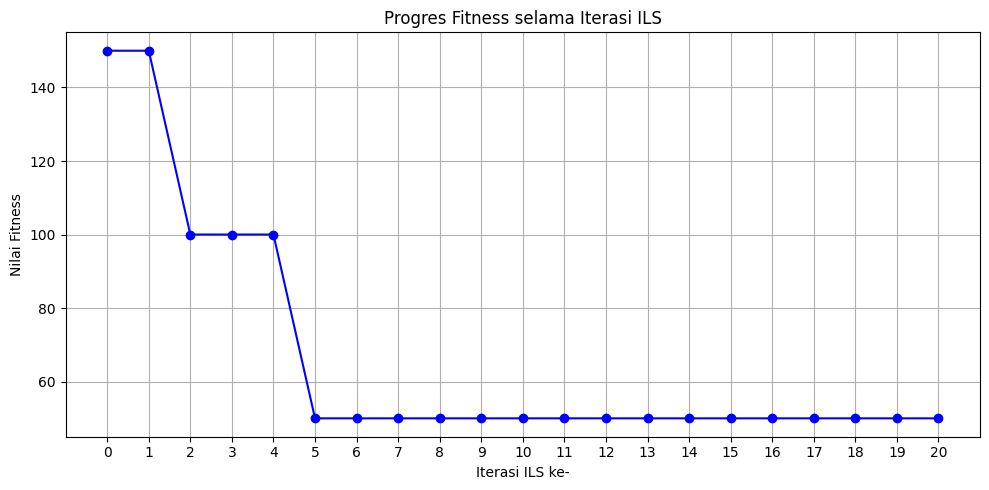

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import matplotlib.pyplot as plt

def plot_fitness_progress(fitness_history):
    plt.figure(figsize=(10, 5))
    plt.plot(fitness_history, marker='o', linestyle='-', color='blue')
    plt.title('Progres Fitness selama Iterasi ILS')
    plt.xlabel('Iterasi ILS ke-')
    plt.ylabel('Nilai Fitness')
    plt.grid(True)
    plt.xticks(range(len(fitness_history)))
    plt.tight_layout()
    plt.show()

def visualize_schedule_hierarchical(solusi, events_lookup, rooms_lookup, days_op, start_op_hour, end_op_hour, max_event_end_h):

    # Buat urutan (day, room) dan map ke posisi Y
    day_room_pairs = []
    for day in days_op:
        rooms_for_day = sorted(rooms_lookup.keys())  # urutkan room jika perlu
        for room_id in rooms_for_day:
            day_room_pairs.append((day, room_id))

    y_pos_map = {pair: i for i, pair in enumerate(day_room_pairs)}

    fig, ax = plt.subplots(figsize=(14, 9))

    # Warnai bar berdasar event dan plotnya
    colors = plt.cm.tab20.colors
    color_map = {}

    for event_id, sched in solusi.items():
        if sched is None:
            continue
        day = sched['day_id']
        room_id = sched['room_id']
        start_h = sched['start_hour']
        dur = events_lookup[event_id]['duration_hours']

        y = y_pos_map[(day, room_id)]
        x = start_h
        width = dur
        if event_id not in color_map:
            color_map[event_id] = colors[len(color_map) % len(colors)]

        ax.barh(y, width, left=x, height=0.6, color=color_map[event_id], edgecolor='black')
        ax.text(x + width/2, y, event_id, va='center', ha='center', color='white', fontsize=9, fontweight='bold')

    # Setup axis x
    ax.set_xlim(start_op_hour, max_event_end_h)
    ax.set_xlabel('Jam')
    ax.set_xticks(range(start_op_hour, max_event_end_h + 1))
    ax.grid(axis='x', linestyle='--', alpha=0.7)

    # Setup axis y: tick di posisi setiap (day, room) -> label hanya room
    ax.set_ylim(-1, len(day_room_pairs))
    ax.set_yticks(list(y_pos_map.values()))
    ax.set_yticklabels([rooms_lookup[pair[1]]['room_name'] for pair in day_room_pairs])

    # Label hari di samping kiri axis y
    unique_days = sorted(set(days_op))
    day_start_pos = {}
    for day in unique_days:
        # posisi pertama (terkecil) untuk hari itu di y_pos_map
        positions = [y_pos_map[(day, r)] for r in rooms_lookup.keys()]
        day_start_pos[day] = min(positions)

    # Pasang label hari di kiri luar axis y dengan ax.text dan transform y axis
    for day, ypos in day_start_pos.items():
        ax.axhline(y=ypos - 0.5, color='black', linewidth=1.2)  # garis di atas blok hari
        ax.text(-0.8, ypos + 0.3, f"Hari {day}", va='center', ha='right', transform=ax.get_yaxis_transform(), fontsize=11, fontweight='bold')

    # Tambahan formatting
    ax.invert_yaxis()  # biar hari 1 di atas
    plt.tight_layout()
    plt.show()


# # Contoh pemakaian (sesuaikan variabel berikut dengan data kamu)
# days_op = [1, 2, 3, 4, 5]  # contoh hari Senin sampai Jumat sebagai angka
# visualize_schedule_hierarchical(
#     solusi=hasil_solusi,
#     events_lookup=event_dict_its,
#     rooms_lookup=room_dict_its,
#     days_op=days_op,
#     start_op_hour=8,
#     end_op_hour=17,
#     max_event_end_h=MAX_EVENT_END_HOUR
# )

hasil_solusi, nilai_fitness, fitness_history = iterated_local_search_its(
    jumlah_iterasi_utama=20,
    jumlah_iterasi_hill=100,
    all_event_ids=all_event_ids_its,
    rooms_lookup=room_dict_its,
    days_op=DAYS_OF_WEEK,
    start_op_hour=START_HOUR_OPERATIONAL,
    end_op_hour=END_HOUR_OPERATIONAL,
    max_event_end_h=MAX_EVENT_END_HOUR
)

print("Fitness akhir:", nilai_fitness)
plot_fitness_progress(fitness_history)